# Generting Synthetic Insuance Data

In this notebook will demonstrate methods for generating synthetic insurance data. This notebook is written to accompany the blog post, ... 

In [344]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from faker import Faker
import scipy.stats as st
from sdv.tabular import GaussianCopula
from sklearn.preprocessing import StandardScaler


pd.set_option('display.max_columns', 50)

In [12]:
nor = pd.read_csv("norauto.csv")
usa = pd.read_csv("Auto_Insurance_Claims_Sample.csv")

# Basic data exploration

In [13]:
nor.head()

,Unnamed: 0,Male,Young,DistLimit,GeoRegion,Expo,ClaimAmount,NbClaim
0,1,0,0,12000 km,Low+,0.789,0.0,0
1,2,0,1,12000 km,Medium+,0.200,0.0,0
2,3,0,1,25000-30000 km,Medium+,0.285,0.0,0
3,4,0,0,12000 km,Medium-,0.247,0.0,0
4,5,0,0,12000 km,High-,0.995,18158.0,1


In [14]:
usa.head()

,Customer,Country,State Code,State,Claim Amount,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Claim Reason,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,US,KS,Kansas,276.351928,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Collision,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,US,NE,Nebraska,697.953590,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Scratch/Dent,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,US,OK,Oklahoma,1288.743165,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Collision,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,US,MO,Missouri,764.586183,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Collision,Call Center,529.881344,SUV,Medsize
4,HB64268,US,KS,Kansas,281.369258,No,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Collision,Agent,138.130879,Four-Door Car,Medsize


In [ ]:
Compare distribution of total claims

Text(0.5, 1.0, 'Norweigian Data')

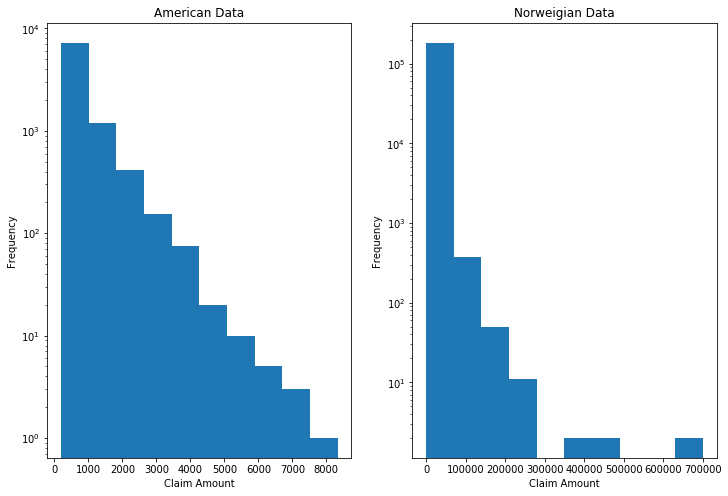

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(12,8))

ax[0].hist(usa["Claim Amount"], log=True)
ax[0].set_xlabel("Claim Amount")
ax[0].set_ylabel("Frequency")
ax[0].set_title("American Data")


ax[1].hist(nor["ClaimAmount"], log=True)
ax[1].set_xlabel("Claim Amount")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Norweigian Data")


For clearer view of issue with American dataset plot number of claims > 0 vs customers with 0 claims.

In [36]:
usa["claim"] = "no claims"
nor["claim"] = "no claims"

usa.loc[usa["Claim Amount"] > 0, "claim" ] = "claimed"
nor.loc[nor["ClaimAmount"] > 0, "claim" ] = "claimed"

In [61]:
usa_vc = usa.claim.value_counts().to_frame()
usa_vc = usa_vc.reset_index()
usa_vc.columns = ["claims", "frequency"]
usa_vc["dataset"] = "American"
usa_vc["pc_freq"] = usa_vc["frequency"] / usa_vc["frequency"].sum() * 100

nor_vc = nor.claim.value_counts().to_frame()
nor_vc = nor_vc.reset_index()
nor_vc.columns = ["claims", "frequency"]
nor_vc["dataset"] = "Norwegian"
nor_vc["pc_freq"] = nor_vc["frequency"] / nor_vc["frequency"].sum() * 100

all_vc = usa_vc.append(nor_vc)
all_vc = all_vc.rename(columns={"dataset": "Dataset"})

all_vc

,claims,frequency,Dataset,pc_freq
0,claimed,9134,American,100.000000
0,no claims,175555,Norwegian,95.410845
1,claimed,8444,Norwegian,4.589155


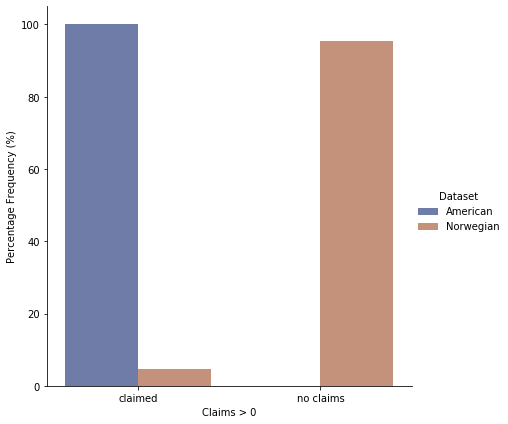

In [63]:
g = sns.catplot(
    data=all_vc, kind="bar",
    x="claims", y="pc_freq", hue="Dataset",
    ci="sd", palette="dark", alpha=.6, height=6
)
plt.xlabel("Claims > 0")
plt.ylabel("Percentage Frequency (%)")
plt.savefig("insurance_claims_comparison.png")

Expect typical insurance portfolio to feature majority of non-claiments for their last period term. The Norwegian dataset matches these assumptions more closely.

## Generating independent synthetic categorical data based on past observations

In [80]:
def generate_distribution(series):
        
    vc = series.value_counts().to_frame()
    vc = vc.reset_index()
    vc.columns = ["cat", "count"]
    vc["pc"] = vc["count"] / vc["count"].sum()    
    return vc


def generate_categorical_data(data, columns, length):
    
    # Initialise blank dataframe
    generated_data = pd.DataFrame()
    
    # Scan through list of columns and generate synthetic data
    for col in cat_columns:

        # Get distribution
        counts = generate_distribution(data[col])
        
        # Generate categorical data
        col_data = np.random.choice(a=counts.cat, size=length, p=counts.pc)
        generated_data[col] = col_data
    
    return generated_data

In [81]:
cat_columns = ['Coverage', 'Education', 
               'EmploymentStatus', 'Gender',  'Location Code',
               'Marital Status', 'Policy Type', 'Policy', 'Claim Reason',
               'Sales Channel', 'Vehicle Class', 'Vehicle Size']

cat_data = generate_categorical_data(usa, cat_columns, 1000)

cat_data.head()

,Coverage,Education,EmploymentStatus,Gender,Location Code,Marital Status,Policy Type,Policy,Claim Reason,Sales Channel,Vehicle Class,Vehicle Size
0,Basic,College,Employed,M,Suburban,Divorced,Personal Auto,Personal L2,Collision,Agent,SUV,Small
1,Basic,Bachelor,Unemployed,M,Suburban,Married,Corporate Auto,Personal L3,Hail,Agent,SUV,Medsize
2,Premium,Doctor,Employed,F,Urban,Divorced,Personal Auto,Special L2,Hail,Branch,Four-Door Car,Small
3,Basic,Bachelor,Unemployed,F,Rural,Divorced,Personal Auto,Personal L2,Hail,Branch,SUV,Medsize
4,Extended,College,Employed,F,Suburban,Married,Personal Auto,Personal L2,Collision,Web,Four-Door Car,Medsize


In [111]:
def visulise_distributions(original, synthetic, columns, path=None):
    
    fig, ax = plt.subplots(len(columns), 2, figsize=(14,16))
    
    
    for i, col in enumerate(columns, start=0):
        
        # Original data
        vc = usa[col].value_counts()
        ax[0][0].set_title("Original Distributions")
        ax[i][0].bar(x=vc.index, height=vc)
        
        # Synthetic data
        vc = cat_data[col].value_counts()
        ax[0][1].set_title("Synthetic Distributions")
        ax[i][1].bar(x=vc.index, height=vc)    
        
    plt.tight_layout()
    if path not None:
        plt.savefig(path)
    

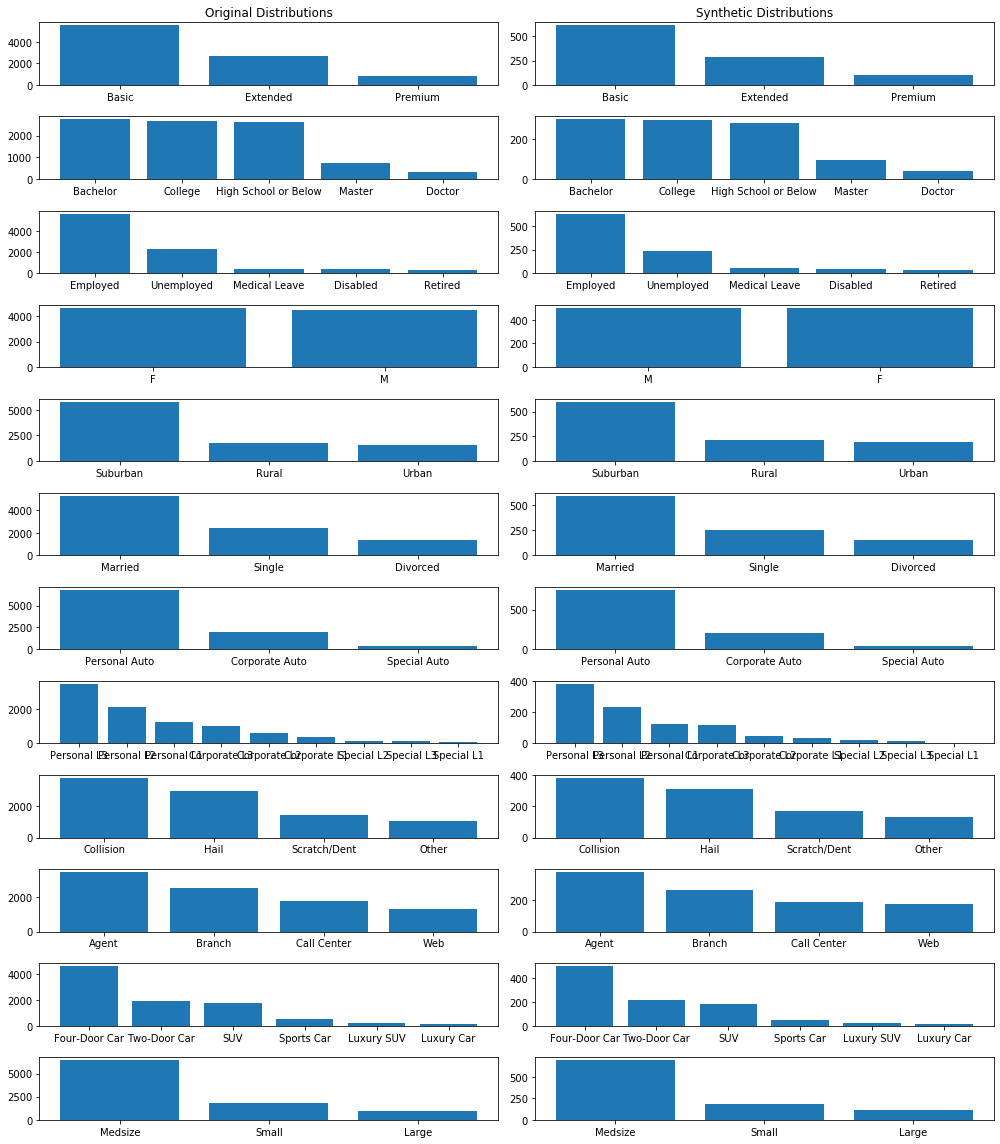

In [112]:
visulise_distributions(usa, cat_data, cat_columns, path="cat_dist_compare.png")

# Novel categorical data with Faker

In [135]:
fake = Faker("en_US")

print("Novel Name:", fake.name())
print("Novel job:", fake.job())
print("Novel Address:", fake.local_latlng(country_code='US'))

Novel Name: Duane Wiley
Novel job: Theme park manager
Novel Address: ('44.73941', '-93.12577', 'Rosemount', 'US', 'America/Chicago')


In [137]:
# Generate independent synthetic numerical data

In [313]:
def model_numerical_data(data, cols, bins=200):
    
    best_fit = pd.DataFrame()
    for col in cols:
        result = best_fit_distribution(data[col], bins=bins)
        result["column"] = col
        best_fit = best_fit.append(result.iloc[0])
    
    return best_fit.reset_index(drop=True)

def best_fit_distribution(data, bins=200):
    
    # Bin data and find x midpoint
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    distributions = [        
    st.alpha, st.expon, st.gamma, st.norm, st.uniform]
    
    results = []
    
    for distribution in distributions:

        # Fit distribution
        params = distribution.fit(data)

        # Generate pdf for fitted distribution and measure fit
        pdf = distribution.pdf(x, loc=params[-2], scale=params[-1], *params[:-2])            
        sse = np.sum(np.power(y - pdf, 2.0))

        # Record fit result
        result = {"distribution": distribution.name,
                  "sse": sse,
                  "params": params}
        results.append(result)
    
    # Convert results to dataframe
    result_df = pd.DataFrame(results)
    result_df = pd.DataFrame(results).sort_values("sse").reset_index(drop=True)
    
    return result_df

In [316]:
# Slice sample of USA data
cols = ['Claim Amount',  
        'Total Claim Amount', 
        'Income', 'Monthly Premium Auto']
usa_sample = usa[cols].iloc[:500]


distribution_fit = model_numerical_data(usa_sample, cols, bins=200)
distribution_fit

,column,distribution,params,sse
0,Claim Amount,gamma,"(1.0056593670907668, 205.05577670875635, 569.1...",7.336765e-06
1,Total Claim Amount,alpha,"(6.807351824890041, -1229.3343965454183, 11048...",3.516412e-05
2,Income,gamma,"(0.4493746408209015, -3.757249353268519e-14, 3...",1.518998e-07
3,Monthly Premium Auto,gamma,"(0.7891412819768158, 60.999999999999986, 40.17...",3.737327e-03


## Generate synthetic data with representitive distributions and correlations using SDV 

In [161]:
# Slice sample of USA data
cols = ['Claim Amount',  
        'Total Claim Amount', 
        'Income', 'Monthly Premium Auto']
usa_sample = usa[cols].iloc[:500]

# Fit Guassian copula
model = GaussianCopula()
model.fit(usa_sample)

# Generate synthetic data
new_data = model.sample(1000)
new_data.head()

/Users/smro/opt/anaconda3/envs/ml/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/smro/opt/anaconda3/envs/ml/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4965: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
/Users/smro/opt/anaconda3/envs/ml/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/Users/smro/opt/anaconda3/envs/ml/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


,Claim Amount,Total Claim Amount,Income,Monthly Premium Auto
0,474.860096,314.077674,106627,91
1,232.478318,522.580875,59883,77
2,420.830049,560.879049,43487,103
3,350.073127,778.824013,-2520,104
4,785.449345,190.200882,66849,89


In [162]:
usa_sample.corr() - new_data.corr()

,Claim Amount,Total Claim Amount,Income,Monthly Premium Auto
Claim Amount,0.000000,-0.021864,-0.008424,0.012186
Total Claim Amount,-0.021864,0.000000,0.004160,0.180916
Income,-0.008424,0.004160,0.000000,0.001285
Monthly Premium Auto,0.012186,0.180916,0.001285,0.000000


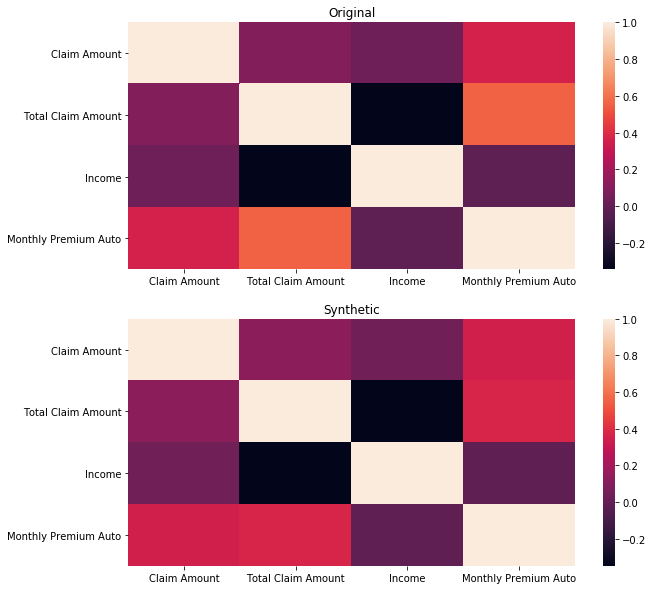

In [163]:
fig, ax = plt.subplots(2, 1, figsize=(10,10), sharey=True)

ax[0].title.set_text("Original")
sns.heatmap(usa_sample.corr(), ax=ax[0])
ax[1].title.set_text("Synthetic")

sns.heatmap(new_data.corr(), ax=ax[1])

In [164]:
def visulise_continuous_distributions(original, synthetic, columns):
    
    fig, ax = plt.subplots(len(columns), 2, figsize=(10,10))
    
    
    for i, col in enumerate(columns, start=0):
        
        all_data = np.concatenate((original[col], synthetic[col]), axis=None)
        max_val = np.max(all_data)
        min_val = np.min(all_data)
        
        # Original data
        ax[i][0].hist(x=original[col])
        ax[i][0].title.set_text(col + ": original")
        ax[i][0].set_xlim(left=min_val, right=max_val)
        
        # Synthetic data
        ax[i][1].hist(x=synthetic[col])    
#         ax[i][0].title(col + ": synthetic")
        ax[i][1].title.set_text(col + ": synthetic")
        ax[i][0].set_xlim(left=min_val, right=max_val)
    
    fig.tight_layout()
        

In [166]:
model.get_distributions()

{'Claim Amount': 'copulas.univariate.log_laplace.LogLaplace',
 'Total Claim Amount': 'copulas.univariate.student_t.StudentTUnivariate',
 'Income': 'copulas.univariate.gaussian.GaussianUnivariate',
 'Monthly Premium Auto': 'copulas.univariate.gamma.GammaUnivariate'}

In [167]:
model.get_parameters()

{'covariance__0__0': 1.0,
 'covariance__1__0': 0.15938457664318262,
 'covariance__1__1': 1.0,
 'covariance__2__0': 0.05475562083272214,
 'covariance__2__1': -0.3671514015841954,
 'covariance__2__2': 1.0,
 'covariance__3__0': 0.4426254045579211,
 'covariance__3__1': 0.4742776155681671,
 'covariance__3__2': -0.011681042332333049,
 'covariance__3__3': 1.0,
 'univariates__Claim Amount__c': 1.99690873677807,
 'univariates__Claim Amount__loc': 0.5479289035479353,
 'univariates__Claim Amount__scale': 6.339470505951291,
 'univariates__Total Claim Amount__df': 4.591220860049967,
 'univariates__Total Claim Amount__loc': 406.8253625980428,
 'univariates__Total Claim Amount__scale': 5.298243353500666,
 'univariates__Income__loc': 35966.104,
 'univariates__Income__scale': 10.288879141282704,
 'univariates__Monthly Premium Auto__a': 0.7891412819768158,
 'univariates__Monthly Premium Auto__loc': 60.999999999999986,
 'univariates__Monthly Premium Auto__scale': 3.6933310306449183,
 'num_rows': 500}

## Simple feature contraints

Some of the features should not have negative values. Will clip values with numpy and see how this effects correlations.

In [168]:
for col in new_data:
    new_data[col] = np.clip(new_data[col], a_min=0, a_max=None)

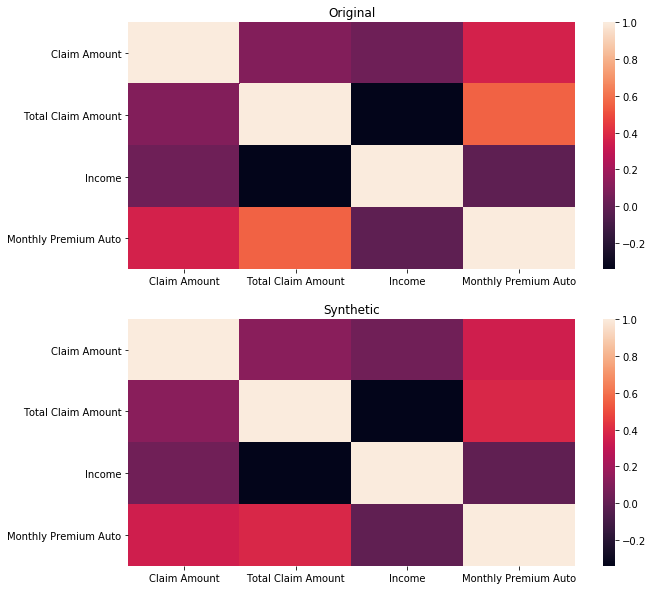

In [169]:
fig, ax = plt.subplots(2, 1, figsize=(10,10), sharey=True)

ax[0].title.set_text("Original")
sns.heatmap(usa_sample.corr(), ax=ax[0])
ax[1].title.set_text("Synthetic")

sns.heatmap(new_data.corr(), ax=ax[1])

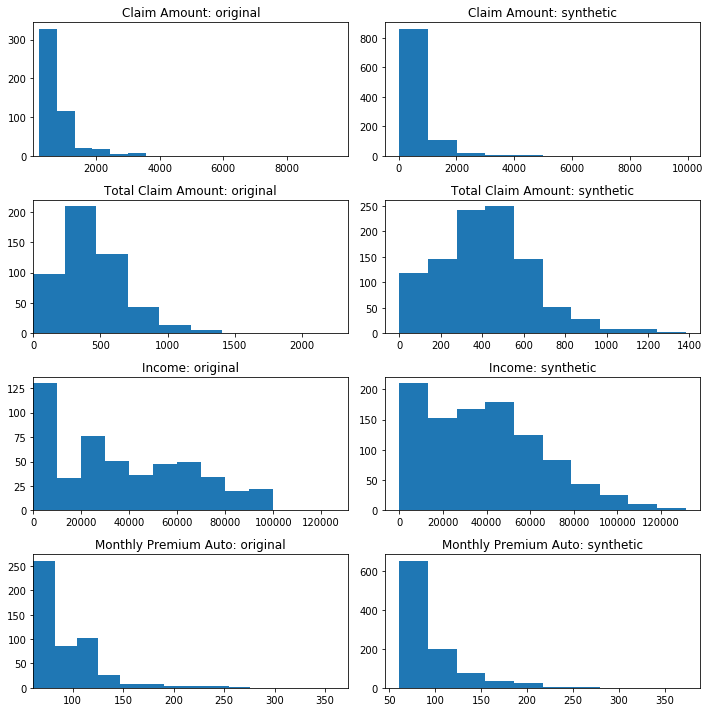

In [170]:
visulise_continuous_distributions(usa_sample, new_data, columns=new_data.columns)

## Generate synthetic target

In [318]:
usa.head()

,Customer,Country,State Code,State,Claim Amount,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Claim Reason,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,claim
0,BU79786,US,KS,Kansas,276.351928,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Collision,Agent,384.811147,Two-Door Car,Medsize,claimed
1,QZ44356,US,NE,Nebraska,697.953590,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Scratch/Dent,Agent,1131.464935,Four-Door Car,Medsize,claimed
2,AI49188,US,OK,Oklahoma,1288.743165,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Collision,Agent,566.472247,Two-Door Car,Medsize,claimed
3,WW63253,US,MO,Missouri,764.586183,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Collision,Call Center,529.881344,SUV,Medsize,claimed
4,HB64268,US,KS,Kansas,281.369258,No,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Collision,Agent,138.130879,Four-Door Car,Medsize,claimed


In [319]:
usa.columns

Index(['Customer', 'Country', 'State Code', 'State', 'Claim Amount',
       'Response', 'Coverage', 'Education', 'Effective To Date',
       'EmploymentStatus', 'Gender', 'Income', 'Location Code',
       'Marital Status', 'Monthly Premium Auto', 'Months Since Last Claim',
       'Months Since Policy Inception', 'Number of Open Complaints',
       'Number of Policies', 'Policy Type', 'Policy', 'Claim Reason',
       'Sales Channel', 'Total Claim Amount', 'Vehicle Class', 'Vehicle Size',
       'claim'],
      dtype='object')

In [347]:
cols = ["Income", 'Monthly Premium Auto', 'Months Since Last Claim', 'Number of Open Complaints', 'Number of Policies']
scaler = StandardScaler()
scaled_cols = [x + "_scaled" for x in cols]
usa[scaled_cols] = scaler.fit_transform(usa[cols])
usa.head()

,Customer,Country,State Code,State,Claim Amount,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Claim Reason,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,claim,x,mu,frequency,Income_scaled,Monthly Premium Auto_scaled,Months Since Last Claim_scaled,Number of Open Complaints_scaled,Number of Policies_scaled
0,BU79786,US,KS,Kansas,276.351928,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Collision,Agent,384.811147,Two-Door Car,Medsize,claimed,-0.933526,0.999907,0,0.612827,-0.703925,1.678099,-0.42225,-0.822648
1,QZ44356,US,NE,Nebraska,697.953590,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Scratch/Dent,Agent,1131.464935,Four-Door Car,Medsize,claimed,-0.988500,0.999901,2,-1.239617,0.022691,-0.208186,-0.42225,2.106160
2,AI49188,US,OK,Oklahoma,1288.743165,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Collision,Agent,566.472247,Two-Door Car,Medsize,claimed,-0.938433,0.999906,1,0.365710,0.429596,0.288205,-0.42225,-0.404247
3,WW63253,US,MO,Missouri,764.586183,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Collision,Call Center,529.881344,SUV,Medsize,claimed,-0.986900,0.999901,0,-1.239617,0.371467,0.288205,-0.42225,1.687759
4,HB64268,US,KS,Kansas,281.369258,No,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Collision,Agent,138.130879,Four-Door Car,Medsize,claimed,-0.947564,0.999905,1,0.203390,-0.587666,-0.307465,-0.42225,-0.822648


In [358]:
# Generate synthetic frequency

# Linear function
w1 = 1.5
w2 = 1.1
w3 = 0.2
w4 = 1
w5 = 1.6
s = 0.0001
c = -1

usa["x"] = (
    w1 * usa["Income_scaled"] + 
    w2 * usa['Monthly Premium Auto_scaled'] + 
    w3 * usa['Months Since Last Claim_scaled'] + 
    w4 * usa['Number of Open Complaints_scaled'] + 
    w5 * usa['Number of Policies_scaled']) * s + c

a = 0.0001
b = -3

# Log link function for x to synthetic mean
usa["mu"] = np.exp(a * usa["x"] + b)

# Synthetic frequency drawn from poisson distribution
usa["frequency"] = np.random.poisson(usa["mu"])

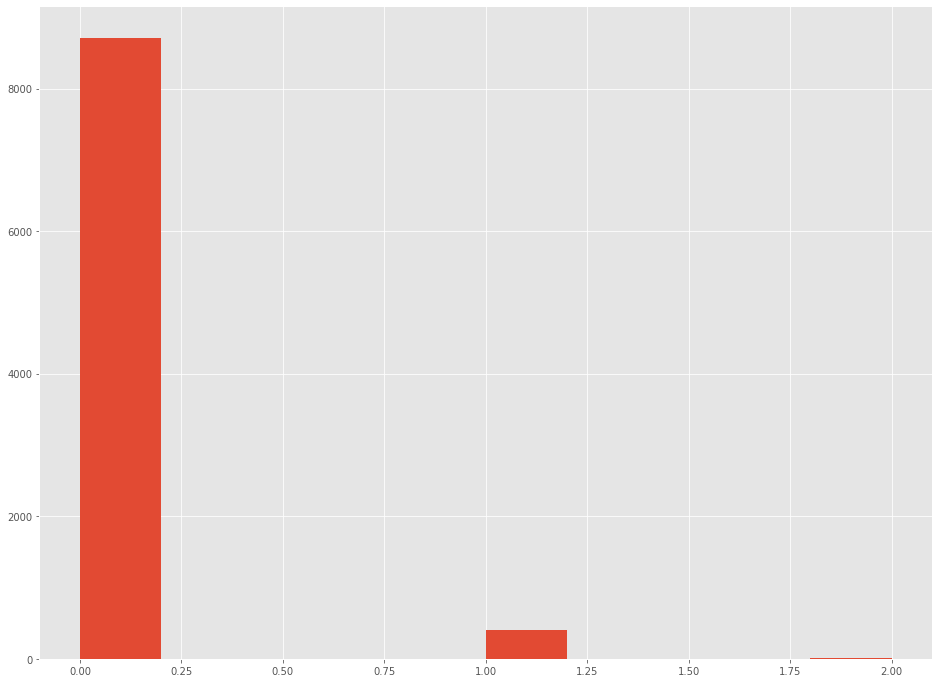

In [360]:
usa["frequency"].hist()

# Compare synthetic target distribution to Norweigian data

In [367]:
nor.head()

,Unnamed: 0,Male,Young,DistLimit,GeoRegion,Expo,ClaimAmount,NbClaim,claim
0,1,0,0,12000 km,Low+,0.789,0.0,0,no claims
1,2,0,1,12000 km,Medium+,0.200,0.0,0,no claims
2,3,0,1,25000-30000 km,Medium+,0.285,0.0,0,no claims
3,4,0,0,12000 km,Medium-,0.247,0.0,0,no claims
4,5,0,0,12000 km,High-,0.995,18158.0,1,claimed


In [373]:
usa_vc = usa["frequency"].value_counts().to_frame()
usa_vc = usa_vc.reset_index()
usa_vc.columns = ["claims", "frequency"]
usa_vc["dataset"] = "Synthetic"
usa_vc["pc_freq"] = usa_vc["frequency"] / usa_vc["frequency"].sum() * 100

nor_vc = nor.NbClaim.value_counts().to_frame()
nor_vc = nor_vc.reset_index()
nor_vc.columns = ["claims", "frequency"]
nor_vc["dataset"] = "Norwegian Observations"
nor_vc["pc_freq"] = nor_vc["frequency"] / nor_vc["frequency"].sum() * 100

all_vc = usa_vc.append(nor_vc)
all_vc = all_vc.rename(columns={"dataset": "Dataset"})

all_vc

,claims,frequency,Dataset,pc_freq
0,0,8718,Synthetic,95.445588
1,1,409,Synthetic,4.477775
2,2,7,Synthetic,0.076637
0,0,175555,Norwegian Observations,95.410845
1,1,8131,Norwegian Observations,4.419046
2,2,298,Norwegian Observations,0.161957
3,3,15,Norwegian Observations,0.008152


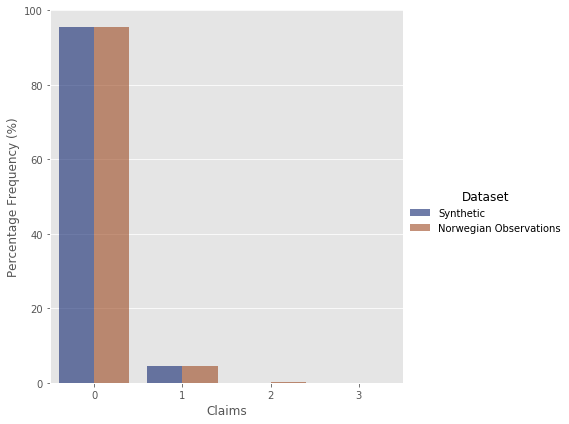

In [374]:
g = sns.catplot(
    data=all_vc, kind="bar",
    x="claims", y="pc_freq", hue="Dataset",
    ci="sd", palette="dark", alpha=.6, height=6
)
plt.xlabel("Claims")
plt.ylabel("Percentage Frequency (%)")
plt.savefig("insurance_claims_comparison.png")